In [10]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons

import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import warnings

from SVMplus import SVMPlus, MulticlassSVMPlus


Single Trial Analysis with Consistent Data:
PERFORMANCE RESULTS
TRAINING ACCURACY:
  SVM+ Accuracy:        0.971
  Standard SVM:         0.943
  Improvement:          +0.029

TEST ACCURACY:
  SVM+ Accuracy:        0.867
  Standard SVM:         0.767
  Improvement:          +0.100

TRAINING MISCLASSIFIED POINTS:
  SVM+:                 2/70 points
  Standard SVM:         4/70 points
  Difference:           2 fewer errors with SVM+

TEST MISCLASSIFIED POINTS:
  SVM+:                 4/30 points
  Standard SVM:         7/30 points
  Difference:           3 fewer errors with SVM+

SUMMARY:
  Total training samples: 70
  Total test samples:     30
  Total error reduction:  5 points


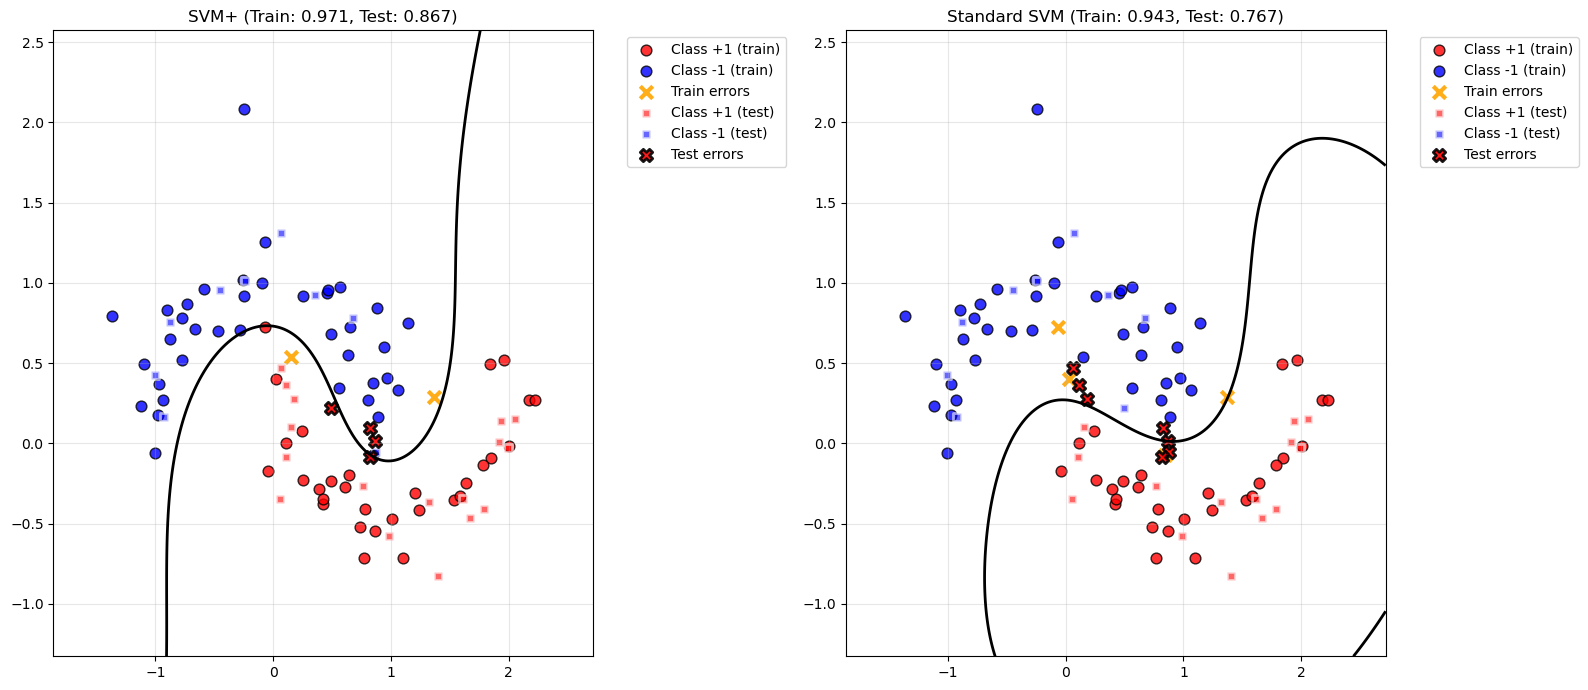

In [11]:
def generate_noisy_data(n_samples=100):
    """Generate moons dataset with noise levels as privileged information"""
    np.random.seed(42)
    
    # Generate clean moons dataset
    X_clean, y = make_moons(n_samples=n_samples, noise=0.0, random_state=42)
    
    # Convert to {-1, 1}
    y = np.where(y == 0, -1, 1)
    
    # Generate varying noise levels
    noise_levels = np.random.uniform(0.05, 0.3, n_samples)
    
    # Add noise to data
    noise_x = np.random.randn(n_samples) * noise_levels
    noise_y = np.random.randn(n_samples) * noise_levels
    X_noisy = X_clean + np.column_stack([noise_x, noise_y])
    
    # Privileged information: noise characteristics
    X_star = np.column_stack([
        noise_levels,
        np.abs(noise_x),
        np.abs(noise_y),
        np.sqrt(noise_x**2 + noise_y**2)
    ])
    
    return X_noisy, X_star, y

def compare_and_plot_models(n_samples=100):
    """Compare SVM+ vs Standard SVM performance and plot using SAME data"""
    
    # Generate data ONCE
    X, X_star, y = generate_noisy_data(n_samples)
    
    # Train/test split
    train_size = int(0.7 * n_samples)
    X_train, X_test = X[:train_size], X[train_size:]
    X_star_train = X_star[:train_size]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train SVM+
    svm_plus = SVMPlus(C=1.0, gamma=1.0)
    svm_plus.fit(X_train, X_star_train, y_train)
    
    # Train Standard SVM
    svm_standard = SVC(kernel='rbf', C=1.0, gamma=1.0)
    svm_standard.fit(X_train, y_train)
    
    # Make predictions on BOTH training and test data
    train_pred_plus = svm_plus.predict(X_train)
    train_pred_standard = svm_standard.predict(X_train)
    test_pred_plus = svm_plus.predict(X_test)
    test_pred_standard = svm_standard.predict(X_test)
    
    # Calculate training accuracies
    train_acc_plus = np.mean(train_pred_plus == y_train)
    train_acc_standard = np.mean(train_pred_standard == y_train)
    
    # Calculate test accuracies
    test_acc_plus = np.mean(test_pred_plus == y_test)
    test_acc_standard = np.mean(test_pred_standard == y_test)
    
    # Calculate misclassified points
    train_errors_plus = np.sum(train_pred_plus != y_train)
    train_errors_standard = np.sum(train_pred_standard != y_train)
    test_errors_plus = np.sum(test_pred_plus != y_test)
    test_errors_standard = np.sum(test_pred_standard != y_test)
    
    # Print comprehensive results
    print("PERFORMANCE RESULTS")
    print("=" * 50)
    
    print(f"TRAINING ACCURACY:")
    print(f"  SVM+ Accuracy:        {train_acc_plus:.3f}")
    print(f"  Standard SVM:         {train_acc_standard:.3f}")
    print(f"  Improvement:          {train_acc_plus - train_acc_standard:+.3f}")
    
    print(f"\nTEST ACCURACY:")
    print(f"  SVM+ Accuracy:        {test_acc_plus:.3f}")
    print(f"  Standard SVM:         {test_acc_standard:.3f}")
    print(f"  Improvement:          {test_acc_plus - test_acc_standard:+.3f}")
    
    print(f"\nTRAINING MISCLASSIFIED POINTS:")
    print(f"  SVM+:                 {train_errors_plus}/{len(y_train)} points")
    print(f"  Standard SVM:         {train_errors_standard}/{len(y_train)} points")
    print(f"  Difference:           {train_errors_standard - train_errors_plus} fewer errors with SVM+")
    
    print(f"\nTEST MISCLASSIFIED POINTS:")
    print(f"  SVM+:                 {test_errors_plus}/{len(y_test)} points")
    print(f"  Standard SVM:         {test_errors_standard}/{len(y_test)} points")
    print(f"  Difference:           {test_errors_standard - test_errors_plus} fewer errors with SVM+")
    
    print(f"\nSUMMARY:")
    print(f"  Total training samples: {len(y_train)}")
    print(f"  Total test samples:     {len(y_test)}")
    print(f"  Total error reduction:  {(train_errors_standard - train_errors_plus) + (test_errors_standard - test_errors_plus)} points")
    
    # Plot decision boundaries using THE SAME DATA
    plot_boundaries_with_data(X_train, y_train, X_test, y_test, 
                             svm_plus, svm_standard, 
                             train_pred_plus, train_pred_standard,
                             test_pred_plus, test_pred_standard,
                             train_acc_plus, train_acc_standard,
                             test_acc_plus, test_acc_standard)
    
    return test_acc_plus, test_acc_standard

def plot_boundaries_with_data(X_train, y_train, X_test, y_test, 
                             svm_plus, svm_standard, 
                             train_pred_plus, train_pred_standard,
                             test_pred_plus, test_pred_standard,
                             train_acc_plus, train_acc_standard,
                             test_acc_plus, test_acc_standard):
    """Plot decision boundaries using provided data and predictions"""
    
    # Create mesh for decision boundary
    h = 0.02
    x_min = min(X_train[:, 0].min(), X_test[:, 0].min()) - 0.5
    x_max = max(X_train[:, 0].max(), X_test[:, 0].max()) + 0.5
    y_min = min(X_train[:, 1].min(), X_test[:, 1].min()) - 0.5
    y_max = max(X_train[:, 1].max(), X_test[:, 1].max()) + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # SVM+ plot
    Z1 = svm_plus.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z1 = Z1.reshape(xx.shape)
    ax1.contour(xx, yy, Z1, levels=[0], colors='black', linewidths=2)
    
    # Plot training data - correctly classified
    correct_train_plus = (train_pred_plus == y_train)
    ax1.scatter(X_train[correct_train_plus & (y_train == 1), 0], 
                X_train[correct_train_plus & (y_train == 1), 1], 
                c='red', s=60, label='Class +1 (train)', alpha=0.8, edgecolors='black')
    ax1.scatter(X_train[correct_train_plus & (y_train == -1), 0], 
                X_train[correct_train_plus & (y_train == -1), 1], 
                c='blue', s=60, label='Class -1 (train)', alpha=0.8, edgecolors='black')
    
    # Plot training data - misclassified
    incorrect_train_plus = ~correct_train_plus
    if np.any(incorrect_train_plus):
        ax1.scatter(X_train[incorrect_train_plus, 0], X_train[incorrect_train_plus, 1], 
                    c='orange', s=80, marker='x', alpha=0.9, linewidth=3,
                    label='Train errors')
    
    # Plot test data - correctly classified
    correct_test_plus = (test_pred_plus == y_test)
    ax1.scatter(X_test[correct_test_plus & (y_test == 1), 0], 
                X_test[correct_test_plus & (y_test == 1), 1], 
                c='red', s=40, marker='s', alpha=0.6, edgecolors='white', linewidth=2,
                label='Class +1 (test)')
    ax1.scatter(X_test[correct_test_plus & (y_test == -1), 0], 
                X_test[correct_test_plus & (y_test == -1), 1], 
                c='blue', s=40, marker='s', alpha=0.6, edgecolors='white', linewidth=2,
                label='Class -1 (test)')
    
    # Plot test data - misclassified
    incorrect_test_plus = ~correct_test_plus
    if np.any(incorrect_test_plus):
        ax1.scatter(X_test[incorrect_test_plus, 0], X_test[incorrect_test_plus, 1], 
                    c='red', s=80, marker='X', alpha=0.9, edgecolors='black', linewidth=2,
                    label='Test errors')
    
    ax1.set_title(f'SVM+ (Train: {train_acc_plus:.3f}, Test: {test_acc_plus:.3f})')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Standard SVM plot
    Z2 = svm_standard.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z2 = Z2.reshape(xx.shape)
    ax2.contour(xx, yy, Z2, levels=[0], colors='black', linewidths=2)
    
    # Plot training data - correctly classified
    correct_train_standard = (train_pred_standard == y_train)
    ax2.scatter(X_train[correct_train_standard & (y_train == 1), 0], 
                X_train[correct_train_standard & (y_train == 1), 1], 
                c='red', s=60, label='Class +1 (train)', alpha=0.8, edgecolors='black')
    ax2.scatter(X_train[correct_train_standard & (y_train == -1), 0], 
                X_train[correct_train_standard & (y_train == -1), 1], 
                c='blue', s=60, label='Class -1 (train)', alpha=0.8, edgecolors='black')
    
    # Plot training data - misclassified
    incorrect_train_standard = ~correct_train_standard
    if np.any(incorrect_train_standard):
        ax2.scatter(X_train[incorrect_train_standard, 0], X_train[incorrect_train_standard, 1], 
                    c='orange', s=80, marker='x', alpha=0.9, linewidth=3,
                    label='Train errors')
    
    # Plot test data - correctly classified
    correct_test_standard = (test_pred_standard == y_test)
    ax2.scatter(X_test[correct_test_standard & (y_test == 1), 0], 
                X_test[correct_test_standard & (y_test == 1), 1], 
                c='red', s=40, marker='s', alpha=0.6, edgecolors='white', linewidth=2,
                label='Class +1 (test)')
    ax2.scatter(X_test[correct_test_standard & (y_test == -1), 0], 
                X_test[correct_test_standard & (y_test == -1), 1], 
                c='blue', s=40, marker='s', alpha=0.6, edgecolors='white', linewidth=2,
                label='Class -1 (test)')
    
    # Plot test data - misclassified
    incorrect_test_standard = ~correct_test_standard
    if np.any(incorrect_test_standard):
        ax2.scatter(X_test[incorrect_test_standard, 0], X_test[incorrect_test_standard, 1], 
                    c='red', s=80, marker='X', alpha=0.9, edgecolors='black', linewidth=2,
                    label='Test errors')
    
    ax2.set_title(f'Standard SVM (Train: {train_acc_standard:.3f}, Test: {test_acc_standard:.3f})')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def simple_comparison():
    """Run simple comparison for moons dataset with multiple trials"""
    # Run multiple trials for more reliable results
    svm_plus_scores = []
    svm_standard_scores = []
    
    for trial in range(5):  # 5 trials with different random seeds
        np.random.seed(42 + trial)
        # Generate data for this trial
        X, X_star, y = generate_noisy_data(n_samples=100)
        
        # Train/test split
        train_size = int(0.7 * 100)
        X_train, X_test = X[:train_size], X[train_size:]
        X_star_train = X_star[:train_size]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Train models
        svm_plus = SVMPlus(C=1.0, gamma=1.0)
        svm_plus.fit(X_train, X_star_train, y_train)
        
        svm_standard = SVC(kernel='rbf', C=1.0, gamma=1.0)
        svm_standard.fit(X_train, y_train)
        
        # Predictions
        y_pred_plus = svm_plus.predict(X_test)
        y_pred_standard = svm_standard.predict(X_test)
        
        # Accuracies
        acc_plus = np.mean(y_pred_plus == y_test)
        acc_standard = np.mean(y_pred_standard == y_test)
        
        svm_plus_scores.append(acc_plus)
        svm_standard_scores.append(acc_standard)
    
    # Calculate averages
    avg_plus = np.mean(svm_plus_scores)
    avg_standard = np.mean(svm_standard_scores)  
    return avg_plus, avg_standard

# Simple execution
if __name__ == "__main__":
    # Performance comparison over multiple trials
    simple_comparison()
    
    # Single trial with detailed plot using SAME data
    print("\n" + "="*50)
    print("Single Trial Analysis with Consistent Data:")
    print("="*50)
    compare_and_plot_models(n_samples=100)

Multiclass SVM+ vs Standard SVM - 3-Class Dataset with Privileged Info
Training Multiclass SVM+...
Training Standard Multiclass SVM...
TRAINING ACCURACY:
  Multiclass SVM+:   0.967
  Standard SVM:      0.975
  Improvement:       -0.008

TEST ACCURACY:
  Multiclass SVM+:   0.917
  Standard SVM:      0.900
  Improvement:       +0.017

TRAINING MISCLASSIFIED POINTS:
  Multiclass SVM+:   4/120 points
  Standard SVM:      3/120 points
  Difference:        -1 fewer errors with SVM+

TEST MISCLASSIFIED POINTS:
  Multiclass SVM+:   15/180 points
  Standard SVM:      18/180 points
  Difference:        3 fewer errors with SVM+

MODEL INFO:
  Binary classifiers: 3
  Training samples:   120
  Test samples:       180
  Privileged features: 12
  Total error reduction: 2 points


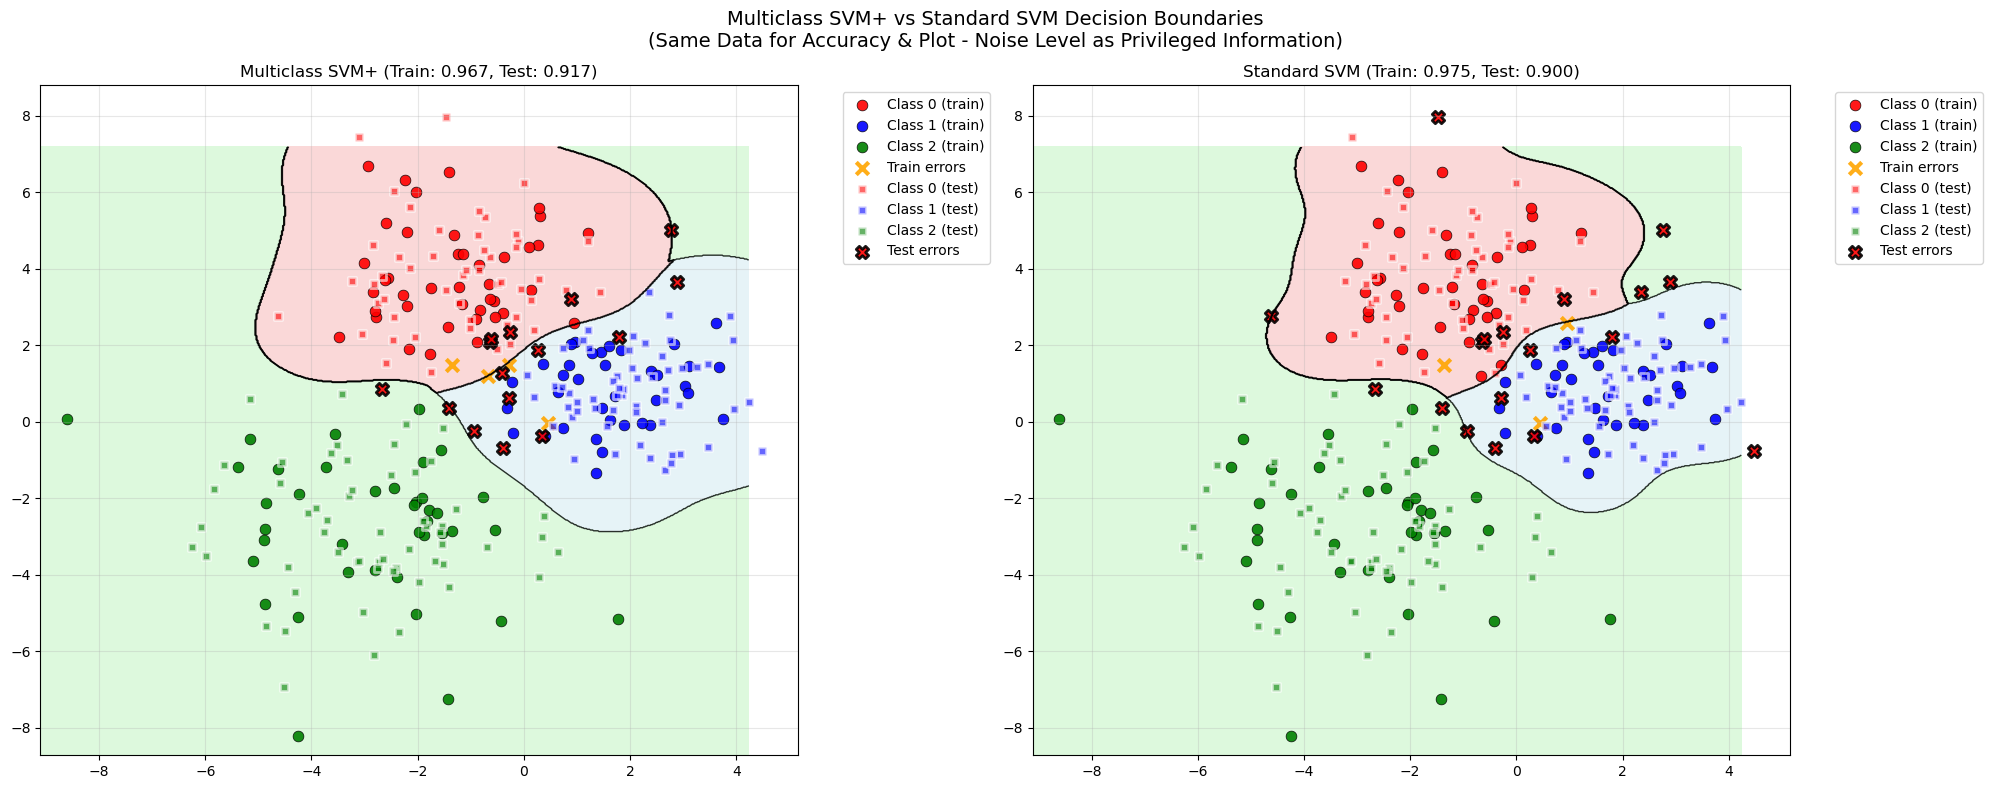


Sample multiclass predictions:
  Sample 0: True=2, Pred=2, Proba=[0.04220191 0.         0.95779809]
  Sample 1: True=0, Pred=1, Proba=[0.         0.86802062 0.13197938]
  Sample 2: True=0, Pred=0, Proba=[0.99113219 0.00886781 0.        ]
  Sample 3: True=1, Pred=1, Proba=[0.         0.90450937 0.09549063]
  Sample 4: True=2, Pred=2, Proba=[0.00579298 0.         0.99420702]


In [48]:
# Multiclass-only example with train/test accuracy
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.svm import SVC
    import matplotlib.pyplot as plt
    
    print("Multiclass SVM+ vs Standard SVM - 3-Class Dataset with Privileged Info")
    print("=" * 75)
    
    def plot_decision_boundary(X_train, y_train, X_test, y_test, clf, title, ax,
                              train_pred=None, test_pred=None):
        """Plot decision boundary for a classifier with both train and test points showing actual predictions"""
        h = 0.02
        # Use training data range for mesh
        x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
        y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # For multiclass, predict the class for each point in the mesh
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        if hasattr(clf, 'classes_') and len(clf.classes_) > 2:
            # Multiclass - predict actual classes for each mesh point
            Z = clf.predict(mesh_points)
        else:
            # Binary - use decision function
            Z = clf.decision_function(mesh_points)
        
        Z = Z.reshape(xx.shape)
        
        # Plot decision regions for multiclass
        if hasattr(clf, 'classes_') and len(clf.classes_) > 2:
            colors_map = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']
            # Create a color map for the background regions
            import matplotlib.colors as mcolors
            
            # Plot colored regions for each class
            unique_classes = np.unique(Z)
            for i, class_val in enumerate(unique_classes):
                mask = Z == class_val
                ax.contourf(xx, yy, mask.astype(int), levels=[0.5, 1.5], 
                           colors=[colors_map[int(class_val) % len(colors_map)]], alpha=0.3)
            
            # Plot decision boundaries between regions
            ax.contour(xx, yy, Z, levels=len(unique_classes)-1, colors='black', linewidths=1, alpha=0.8)
        else:
            # Binary case
            ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
        
        colors = ['red', 'blue', 'green', 'orange']
        unique_y = np.unique(y_train)
        
        # Plot training points - correctly classified
        if train_pred is not None:
            correct_train = (train_pred == y_train)
            for i, class_val in enumerate(unique_y):
                mask_train = (y_train == class_val) & correct_train
                ax.scatter(X_train[mask_train, 0], X_train[mask_train, 1], 
                          c=colors[i % len(colors)], s=60, alpha=0.9,
                          label=f'Class {class_val} (train)', edgecolors='black', linewidth=0.5)
            
            # Plot training misclassifications
            incorrect_train = ~correct_train
            if np.any(incorrect_train):
                ax.scatter(X_train[incorrect_train, 0], X_train[incorrect_train, 1], 
                          c='orange', s=80, marker='x', alpha=0.9, linewidth=3,
                          label='Train errors')
        else:
            # Fallback: plot by true class if no predictions provided
            for i, class_val in enumerate(unique_y):
                mask_train = y_train == class_val
                ax.scatter(X_train[mask_train, 0], X_train[mask_train, 1], 
                          c=colors[i % len(colors)], s=60, alpha=0.9,
                          label=f'Class {class_val} (train)', edgecolors='black', linewidth=0.5)
        
        # Plot test points - correctly classified
        if test_pred is not None:
            correct_test = (test_pred == y_test)
            for i, class_val in enumerate(unique_y):
                mask_test = (y_test == class_val) & correct_test
                ax.scatter(X_test[mask_test, 0], X_test[mask_test, 1], 
                          c=colors[i % len(colors)], s=40, alpha=0.6,
                          marker='s', edgecolors='white', linewidth=2,
                          label=f'Class {class_val} (test)')
            
            # Plot test misclassifications
            incorrect_test = ~correct_test
            if np.any(incorrect_test):
                ax.scatter(X_test[incorrect_test, 0], X_test[incorrect_test, 1], 
                          c='red', s=80, marker='X', alpha=0.9, edgecolors='black', linewidth=2,
                          label='Test errors')
        else:
            # Fallback: plot by true class if no predictions provided
            for i, class_val in enumerate(unique_y):
                mask_test = y_test == class_val
                ax.scatter(X_test[mask_test, 0], X_test[mask_test, 1], 
                          c=colors[i % len(colors)], s=40, alpha=0.6,
                          marker='s', edgecolors='white', linewidth=2,
                          label=f'Class {class_val} (test)')
        
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    # MULTICLASS CLASSIFICATION - Generate data ONCE
    np.random.seed(60)
    n_per_class = 100  # Increased sample size
    n_multi = 3 * n_per_class
    
    # Create 3 distinct blob clusters
    X_multi_clean, y_multi = make_blobs(
        n_samples=n_multi, 
        centers=3, 
        n_features=2,
        center_box=(-4, 4),  # Wider separation
        cluster_std=0.8,     # Controlled cluster spread
        random_state=42
    )
    
    # Add class-dependent noise with different characteristics
    noise_levels_multi = np.zeros(n_multi)
    noise_x_multi = np.zeros(n_multi)
    noise_y_multi = np.zeros(n_multi)
    data_quality = np.zeros(n_multi)  # Privileged feature
    
    for class_id in range(3):
        mask = y_multi == class_id
        n_class = np.sum(mask)
        
        if class_id == 0:
            # Class 0: Low noise, high quality
            noise_levels_multi[mask] = np.random.uniform(0.8, 1.6, n_class)
            data_quality[mask] = np.random.uniform(0.8, 1.0, n_class)
        elif class_id == 1:
            # Class 1: Low noise, high quality
            noise_levels_multi[mask] = np.random.uniform(0.5, 1.2, n_class)
            data_quality[mask] = np.random.uniform(0.4, 0.7, n_class)
        else:
            # Class 2: High noise, low quality
            noise_levels_multi[mask] = np.random.uniform(1, 2, n_class)
            data_quality[mask] = np.random.uniform(0.2, 0.4, n_class)
        
        # Generate correlated noise
        noise_x_multi[mask] = np.random.randn(n_class) * noise_levels_multi[mask]
        noise_y_multi[mask] = np.random.randn(n_class) * noise_levels_multi[mask]
    
    # Apply noise to create final dataset
    X_multi_noisy = X_multi_clean + np.column_stack([noise_x_multi, noise_y_multi])
    
    # EXTENSIVE privileged features for multiclass
    distance_to_center = np.sqrt(np.sum(X_multi_clean**2, axis=1))  # Distance from origin
    noise_magnitude = np.sqrt(noise_x_multi**2 + noise_y_multi**2)
    signal_to_noise = distance_to_center / (noise_magnitude + 1e-8)
    measurement_confidence = data_quality * (1 - noise_levels_multi)
    noise_asymmetry = np.abs(noise_x_multi) - np.abs(noise_y_multi)
    
    X_star_multi = np.column_stack([
        noise_levels_multi,      # Base noise level
        np.abs(noise_x_multi),   # X-direction noise
        np.abs(noise_y_multi),   # Y-direction noise  
        data_quality,            # Data collection quality
        distance_to_center,      # Distance from origin
        noise_magnitude,         # Total noise magnitude
        signal_to_noise,         # Signal-to-noise ratio
        measurement_confidence,  # Overall measurement confidence
        noise_asymmetry,         # Directional noise bias
        noise_x_multi * noise_y_multi,  # Noise interaction
        X_multi_clean[:, 0] * noise_levels_multi,  # Position-noise interaction X
        X_multi_clean[:, 1] * noise_levels_multi   # Position-noise interaction Y
    ])
    
    # Split multiclass data ONCE
    train_size_multi = int(0.4 * n_multi)
    indices = np.random.permutation(n_multi)
    train_idx, test_idx = indices[:train_size_multi], indices[train_size_multi:]
    
    X_train_multi = X_multi_noisy[train_idx]
    X_star_train_multi = X_star_multi[train_idx]
    y_train_multi, y_test_multi = y_multi[train_idx], y_multi[test_idx]
    X_test_multi = X_multi_noisy[test_idx]
    
    # Train multiclass classifiers
    print("Training Multiclass SVM+...")
    multiclass_svm_plus = MulticlassSVMPlus(C=1.0, gamma=1.0)
    multiclass_svm_plus.fit(X_train_multi, X_star_train_multi, y_train_multi)
    
    print("Training Standard Multiclass SVM...")
    svm_standard_multi = SVC(kernel='rbf', C=1.0, gamma=1.0)
    svm_standard_multi.fit(X_train_multi, y_train_multi)
    
    # Make predictions on THE SAME DATA used for training/testing
    train_pred_plus = multiclass_svm_plus.predict(X_train_multi)
    train_pred_standard = svm_standard_multi.predict(X_train_multi)
    test_pred_plus = multiclass_svm_plus.predict(X_test_multi)
    test_pred_standard = svm_standard_multi.predict(X_test_multi)
    
    # Calculate accuracies
    train_acc_plus = np.mean(train_pred_plus == y_train_multi)
    train_acc_standard = np.mean(train_pred_standard == y_train_multi)
    test_acc_plus = np.mean(test_pred_plus == y_test_multi)
    test_acc_standard = np.mean(test_pred_standard == y_test_multi)
    
    # Calculate misclassified points
    train_misclassified_plus = np.sum(train_pred_plus != y_train_multi)
    train_misclassified_standard = np.sum(train_pred_standard != y_train_multi)
    test_misclassified_plus = np.sum(test_pred_plus != y_test_multi)
    test_misclassified_standard = np.sum(test_pred_standard != y_test_multi)
    
    print(f"TRAINING ACCURACY:")
    print(f"  Multiclass SVM+:   {train_acc_plus:.3f}")
    print(f"  Standard SVM:      {train_acc_standard:.3f}")
    print(f"  Improvement:       {train_acc_plus - train_acc_standard:+.3f}")
    
    print(f"\nTEST ACCURACY:")
    print(f"  Multiclass SVM+:   {test_acc_plus:.3f}")
    print(f"  Standard SVM:      {test_acc_standard:.3f}")
    print(f"  Improvement:       {test_acc_plus - test_acc_standard:+.3f}")
    
    print(f"\nTRAINING MISCLASSIFIED POINTS:")
    print(f"  Multiclass SVM+:   {train_misclassified_plus}/{len(y_train_multi)} points")
    print(f"  Standard SVM:      {train_misclassified_standard}/{len(y_train_multi)} points")
    print(f"  Difference:        {train_misclassified_standard - train_misclassified_plus} fewer errors with SVM+")
    
    print(f"\nTEST MISCLASSIFIED POINTS:")
    print(f"  Multiclass SVM+:   {test_misclassified_plus}/{len(y_test_multi)} points")
    print(f"  Standard SVM:      {test_misclassified_standard}/{len(y_test_multi)} points")
    print(f"  Difference:        {test_misclassified_standard - test_misclassified_plus} fewer errors with SVM+")
    
    print(f"\nMODEL INFO:")
    print(f"  Binary classifiers: {len(multiclass_svm_plus.binary_classifiers_)}")
    print(f"  Training samples:   {len(y_train_multi)}")
    print(f"  Test samples:       {len(y_test_multi)}")
    print(f"  Privileged features: {X_star_multi.shape[1]}")
    print(f"  Total error reduction: {(train_misclassified_standard - train_misclassified_plus) + (test_misclassified_standard - test_misclassified_plus)} points")
    
    # PLOT DECISION BOUNDARIES using THE SAME DATA and ACTUAL PREDICTIONS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot decision boundaries with both train and test points, showing actual predictions
    plot_decision_boundary(X_train_multi, y_train_multi, X_test_multi, y_test_multi, 
                          multiclass_svm_plus, 
                          f'Multiclass SVM+ (Train: {train_acc_plus:.3f}, Test: {test_acc_plus:.3f})', ax1,
                          train_pred=train_pred_plus, test_pred=test_pred_plus)
    plot_decision_boundary(X_train_multi, y_train_multi, X_test_multi, y_test_multi,
                          svm_standard_multi, 
                          f'Standard SVM (Train: {train_acc_standard:.3f}, Test: {test_acc_standard:.3f})', ax2,
                          train_pred=train_pred_standard, test_pred=test_pred_standard)
    
    plt.suptitle('Multiclass SVM+ vs Standard SVM Decision Boundaries\n(Same Data for Accuracy & Plot - Noise Level as Privileged Information)', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Show sample predictions with probabilities
    probas = multiclass_svm_plus.predict_proba(X_test_multi[:5])
    preds = multiclass_svm_plus.predict(X_test_multi[:5])
    print(f"\nSample multiclass predictions:")
    for i, (true, pred, proba) in enumerate(zip(y_test_multi[:5], preds, probas)):
        print(f"  Sample {i}: True={true}, Pred={pred}, Proba={proba}")